# Mapping and Prediction of Incised Features.

In [181]:
%%capture

import numpy as np
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy.ndimage.filters import uniform_filter
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 
from landlab.plot.imshow import imshow_node_grid 
# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, FlowRouter, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

In [182]:
location = (r'D:/PhD/junk')
os.chdir(location)
DEM = 'D:/PhD/junk/hypsometry.nc'
data = xr.open_dataset(DEM)
data

<xarray.Dataset>
Dimensions:     (latitude: 6800, longitude: 8400, z: 20)
Coordinates:
  * latitude    (latitude) float32 -10.0025 -10.0075 ... -43.9925 -43.9975
  * longitude   (longitude) float32 112.003 112.007 112.012 ... 153.992 153.997
Dimensions without coordinates: z
Data variables:
    hypsometry  (z, longitude, latitude) float32 ...
    percentile  (z) float32 ...
Attributes:
    derivation:     Derived from 1-sec SRTM DEM
    creator_name:   Water and Landscape Dynamics group
    creator_url:    http://www.wenfo.org/wald/
    creator_email:  albert.vandijk@anu.edu.au
    institution:    Australian National University
    date_created:   01-Jan-2019
    license:        Creative Commons with Attribution (https://creativecommon...

In [183]:
list(data.variables.keys());

In [184]:
DEM_data = data.hypsometry.sel(z = 0);

In [185]:
min_DEM = minimum_filter(DEM_data, size = 3, mode = 'nearest')

In [186]:
one_km = np.transpose(scipy.ndimage.zoom(min_DEM, 0.5, order = 1));

In [187]:
min_one_km = minimum_filter(one_km, size = 3, mode = 'nearest')

In [188]:
five_km = scipy.ndimage.zoom(min_one_km, 0.2, order = 1);
all_rows = five_km.shape[0];
all_cols = five_km.shape[1];


In [189]:
def x_y_size_test(input_array, resolution_ratio, resample_levels, number_of_options):
    """This function checks the size of the array and ensures that it can be resampled up and down 
    by a factor of three and always result in an array of the original size."""
    # Check number of rows and columns. 
    rows = np.size(input_array, 0)
    columns = np.size(input_array, 1)
    array_sizes = []
    for i in range(1,number_of_options):
        min_dim_size = resolution_ratio ** resample_levels
        ideal_array = i * min_dim_size
        array_sizes.append(ideal_array)
    ideal_row = next(x[1] for x in enumerate(array_sizes) if x[1] > rows)
    ideal_col = next(x[1] for x in enumerate(array_sizes) if x[1] > columns)
    add_rows = ideal_row - rows
    add_columns = ideal_col - columns
    # Create an empty array to the pad if required.
    empty_array = np.zeros((rows + add_rows, columns + add_columns))     
    offset_rows = int(-1 * add_rows)
    offset_columns = int(-1 * add_columns)
    empty_array[:offset_rows, :offset_columns] = input_array
    return empty_array

def resample_resolution_lower(data, ratio):
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    zoom_factor = Fraction(1,3 ** ratio)
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    return resample

def resample_resolution_higher(data, ratio):
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    zoom_factor = 3 ** ratio
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    return resample

def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle

def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator

#Note: using median like this only gives the correct value for circles with odd radius values.

def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent

# The 'extra_arguments' variable requires a value that represents r in the PCTL function defined above.
# The reason it need to be assigned to a seperate variable is that the generic_filter function only allows the
# input function (PCTL in this case) to take one argument (S1). Then, if the input function normally 
# takes more than one argument the 'extra_arguments' variable needs to be defined as a tuple 
# (hence (3,) instead of (3)).

def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees

def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = (2 * (D*(H**2) + E*(G**2) - (F*G*H))) / (G**2 + H**2)
    return plan_curvature

def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature

def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle

def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value

def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y

def Nxtp(x, t, p):
    """Takes a DEM derivative (x, such as slope or elevation percentile 
       and maps it onto the range [0,1] using a non-linear equation with a shape 
       parameter (t) and a threshold parameter (p)"""
    standardise_value = 1/(1+(x/t)**p)
    print (x)
    print (t)
    print (p)
    return standardise_value

def TWI(slope, As):
    """Calculates Topographic Wetness Index (TWI) taking a slope layer in degrees,
    the catchment area of the cell calculated using a chosen flow routing algorithm and 
    the cell resolution of the slope and catchment area layers input as an integer."""
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    W = np.log(np.divide(As, tanB))
    return W

def SPI(slope, As):
    """Calculates Compound Topographic Index (TWI) taking a slope layer in degrees and
    the catchment area of the cell calculated using a chosen flow routing algorithm."""
    slope_radians = np.deg2rad(slope)
    C = np.multiply(As, slope_radians)
    return C
    

def gaussian_filter(image, kernel):
    """This function applies a gaussian smoothing filter to the data. It takes an input DEM
    and kernel file (read in as a numpy array). This is the exact same filter used by MRVBF"""
    convolution = np.mean(np.multiply(kernel, image))
    return convolution

def find_matching_level(L):
    find_divisor_integer = L//2
    find_remainder = L%2
    matching_generalisation_level = find_divisor_integer + find_remainder
    matching_cell_resolution = matching_generalisation_level - find_remainder
    return matching_generalisation_level, matching_cell_resolution

def flow_dir_dataset(flow_rec_prop, catchment_area, generalisation_Lm1):
    """ Create an xarray Dataset containing eight arrays each representing the
    amount of water flowing in the given direction. 
    
        1 . flow_rec_prop == the flow receiver proportion array created by LandLab flow routing.
        2 . catchment_area == the corresponding catchment area array from the landLab flow accumulation.
        surface.
        3. generalisation_Lm1 is simply used to resample all array to have equal dimensions prior
        to being combined so that they can all be pushed into an xarray Dataset.
        
    The resulting Dataset is used to calculate specific catchment area."""
    
    array_direction = xr.Dataset()
    
    for i in range(0,8):
        shell_array = np.copy(catchment_area)
        direction = flow_rec_prop[:,i]
        reshape_direction = direction.reshape(rows,cols)
        direction_array = np.flip(reshape_direction, 0)
        shell_array[0:rows, 0:cols] = direction_array
        shell_array_resample = resample_resolution_higher(shell_array, generalisation_Lm1 - 1)
        catchment_area_resample = resample_resolution_higher(catchment_area, generalisation_Lm1 - 1)
        weighted_direction = xr.DataArray((catchment_area_resample * shell_array_resample),
                                          dims = ['lat', 'lon'])
        array_direction[direction_list[i]] = weighted_direction
        
    E, N, W, S, NE, NW, SW, SE = (array_direction['East'], array_direction['North'],
                             array_direction['West'], array_direction['South'],
                             array_direction['North East'], array_direction['North West'],
                             array_direction['South West'], array_direction['South East'])

    flow_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
    flow_dirs.name = 'flow_directions'
    resolution = 3**(generalisation_Lm1 - 1)
    flow_dirs.attrs['grid cell resolution'] = resolution
    flow_directions = flow_dirs.assign_coords(direction=(['East','North','West','South',
                                   'North East', 'North West','South West', 'South East']))
    return flow_directions

def specific_catchment_area(dir_list):
    
    spca_Dataset = xr.Dataset()

    dir_dicts = [{'Direction': 'East', 'x1': 1, 'x2': -1, 'y1': 2, 'y2': None}, 
                    {'Direction': 'North','x1': None, 'x2': -2, 'y1': 1, 'y2': -1},
                    {'Direction': 'West' , 'x1': 1, 'x2': -1, 'y1': None, 'y2': -2},
                    {'Direction': 'South' , 'x1': 2, 'x2': None, 'y1': 1, 'y2': -1},
                    {'Direction': 'North East' , 'x1': None, 'x2': -2, 'y1': 2, 'y2': None},
                    {'Direction': 'North West' , 'x1': None, 'x2': -2, 'y1': None, 'y2': -2},
                    {'Direction': 'South West' , 'x1': 2, 'x2': None, 'y1': None, 'y2': -2},
                    {'Direction': 'South East', 'x1': 2, 'x2': None, 'y1': 2, 'y2': None}]

    for varname, ds in dir_arrays_all_scales.data_vars.items():
        loop_temp_ds = xr.Dataset()
        for i in range(0,8):
                buffer = ds.sel(direction = dir_list[i]);
                resolution = buffer.attrs['grid cell resolution'];
                if i < 4:
                    flow_width = resolution;
                else: 
                    flow_width = math.sqrt(2) * resolution;
                    
                resample_factor = math.log(resolution, 3);
                buffer_r = resample_resolution_lower(buffer, int(resample_factor));
                lat = buffer_r.shape[0]; lon = buffer_r.shape[1];
                exp = np.zeros((lat + 2,lon + 2));
                exp[dir_dicts[i]['x1']:dir_dicts[i]['x2'],
                        dir_dicts[i]['y1']:dir_dicts[i]['y2']] = np.divide(buffer_r, flow_width);
                spca_shell = exp [1:-1,1:-1];
                spca = xr.DataArray(resample_resolution_higher(spca_shell, int(resample_factor)),
                                              dims = ['lat', 'lon']);
                loop_temp_ds[dir_list[i]] = spca;
                
        E, N, W, S, NE, NW, SW, SE = (loop_temp_ds['East'], loop_temp_ds['North'],
                                loop_temp_ds['West'], loop_temp_ds['South'],
                                loop_temp_ds['North East'], loop_temp_ds['North West'],
                                loop_temp_ds['South West'], loop_temp_ds['South East'])

        spca_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
        resolution = 3**(int(varname[-2:-1]) - 2)
        
        specific_ca = spca_dirs.sum('direction')
        specific_ca.attrs['grid cell resolution'] = resolution
        spca_Dataset['spca' + '_' + varname] = specific_ca
        
    return spca_Dataset

#################################################################################################

def prep_model_grid(original_dem, generalisation_Lm1):
    """This function is used to take a subset of the current workign DEM equal in size to the 
    maximum possible given the resolution of the current processing step. It assesses by how many 
    rows and columns the input DEM needs to be decreased by in order to be perfectly divisible
    by the resolution of the current processing step."""
    divide_by = 3**(int(generalisation_Lm1) - 1)
    nibble_by = original_dem.shape[0] % divide_by
    DEM_subset = np.copy(original_dem)
    if nibble_by == 0:
        return original_dem
    else:
        topo_surface = DEM_subset[0:-nibble_by, 0:-nibble_by]
        return topo_surface
    
def flow_direction_D8(rp):
    """This function takes a model grid with node values indicating the node they are flowing to.
    For example, if grid cell in position (0, 0) has a value of 1 that means it's flowing one
    cell to the right. It sets up a grid with original node values and minus the two. This
    grid can then be converted into flow directions."""
    nodes = np.arange(0,np.multiply(rp.shape[0], rp.shape[1]));
    node_grid = nodes.reshape(rp.shape[0],rp.shape[1]);
    size_of_grid = rp.shape[1]
    prep_dir_grid = rp - node_grid
    North = np.multiply(-1, size_of_grid); prep_dir_grid[prep_dir_grid == North] = 64
    East = 1; prep_dir_grid[prep_dir_grid == East] = 1
    South = size_of_grid; prep_dir_grid[prep_dir_grid == South] = 4
    West = -1; prep_dir_grid[prep_dir_grid == West] = 16
    Northeast = np.multiply(-1, size_of_grid) + 1; prep_dir_grid[prep_dir_grid == Northeast] = 128
    Northwest = np.multiply(-1, size_of_grid) - 1; prep_dir_grid[prep_dir_grid == Northwest] = 32
    Southeast = size_of_grid + 1; prep_dir_grid[prep_dir_grid == Southeast] = 2
    Southwest = size_of_grid - 1; prep_dir_grid[prep_dir_grid == Southwest] = 8
    Sink = 0; prep_dir_grid[prep_dir_grid == Sink] = -1
    return prep_dir_grid


In [190]:
D8_dataset = xr.Dataset()
for i in range(0,2):
    x_start = 0 + i * 140
    x = 540 + i * 140
    for j in range(0, 4):
        y_start = 0 + j * 110
        y = 510 + j * 110
        print(x_start,':', x, y_start,':', y)
        input_DEM = np.nan_to_num(np.copy(five_km[x_start:x,y_start:y]));
        minimum = np.amin(input_DEM)
        mask_template = np.copy(input_DEM)
        mask_template[mask_template != minimum] = 1
        mask_template[mask_template == minimum] = np.nan
        mask = x_y_size_test(mask_template, 3, 5, 100)
        DEM = x_y_size_test(input_DEM, 3, 5, 100)
        DEM[DEM < minimum] = minimum
        array_DEM = {}
        # Setup an xarray Dataset to contain all flow direction DataArrays at each scale of processing.
        dir_arrays_all_scales = xr.Dataset()
        #################################################################################################
        flow_acc_surf = np.copy(DEM);
        flow_dir_surf = np.copy(DEM);
        #################################################################################################
        # This is just ensuring the DEM has the correct properties to work within the model grid 
        # structure of LandLab. The 'prep_model_grid' function is defined above.
        flow_subset = np.copy(input_DEM.astype('float64'))
        #################################################################################################
        # Now determine the actual size of the subset DEM by dividing each axis by the resolution of
        # the current processing step.
        rows = int(flow_subset.shape[0])
        cols = int(flow_subset.shape[1])
        print(rows, cols)
        # Now extract the designated subset from the current working DEM.
        input_surface = flow_acc_surf[0:rows, 0:cols]
        #The output is now fed into a RasterModelGrid to process flow accumulation.
        mg = RasterModelGrid((rows,cols), spacing=(5000, 5000))
        print('mg done')
        mg.add_field('topographic__elevation', input_surface, at = 'node')
        sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        #fa = FlowAccumulator(mg,
        #                    surface = 'topographic__elevation',
        #                    flow_director = 'FlowDirectorD8')
        #print('Accumulating flow')
        #(flow_acc, q) = fa.accumulate_flow()
        #da = np.array(mg.at_node['drainage_area'])
        #dr = da.reshape(rows,cols)
        # Finally insert the flow accumulation subset back into the larger DEM that the subset was taken from
        # and append to dictionary.
        #flow_acc_surf[0:rows, 0:cols] = dr
        #array_DEM.setdefault('CA', []).append(flow_acc_surf);
        fd = FlowDirectorD8(mg, 'topographic__elevation');
        receiver = fd.direct_flow();
        #fd.run_one_step()
        fda = np.array(mg.at_node['flow__link_to_receiver_node']);
        d = fda.reshape(rows,cols);
        frp = np.array(mg.at_node['flow__receiver_node']);
        rp = frp.reshape(rows,cols);
        map_section_D8 = xr.DataArray(rp[0:rows, 0:cols])
        #map_section_flow_acc = xr.DataArray([0:rows, 0:cols])
        D8_dataset['flow_dirs' + str(x_start) + ':' + str(x) + str(y_start) + ':' + str(y)] = map_section



0 : 540 0 : 510
540 510
mg done
0 : 540 110 : 620
540 510
mg done
0 : 540 220 : 730
540 510
mg done
0 : 540 330 : 840
540 510
mg done
140 : 680 0 : 510
540 510
mg done
140 : 680 110 : 620
540 510
mg done
140 : 680 220 : 730
540 510
mg done
140 : 680 330 : 840
540 510
mg done


In [191]:
D8_dataset

<xarray.Dataset>
Dimensions:                  (dim_0: 540, dim_1: 510)
Dimensions without coordinates: dim_0, dim_1
Data variables:
    flow_dirs0:5400:510      (dim_0, dim_1) int32 0 1 2 ... 275397 275398 275399
    flow_dirs0:540110:620    (dim_0, dim_1) int32 0 1 2 ... 275397 275398 275399
    flow_dirs0:540220:730    (dim_0, dim_1) int32 0 1 2 ... 275397 275398 275399
    flow_dirs0:540330:840    (dim_0, dim_1) int32 0 1 2 ... 275397 275398 275399
    flow_dirs140:6800:510    (dim_0, dim_1) int32 0 1 2 ... 275397 275398 275399
    flow_dirs140:680110:620  (dim_0, dim_1) int32 0 1 2 ... 275397 275398 275399
    flow_dirs140:680220:730  (dim_0, dim_1) int32 0 1 2 ... 275397 275398 275399
    flow_dirs140:680330:840  (dim_0, dim_1) int32 0 1 2 ... 275397 275398 275399

In [96]:
octant_a = flow_direction_D8(np.array(D8_dataset['flow_dirs0:5400:510']))
octant_b = flow_direction_D8(np.array(D8_dataset['flow_dirs0:540110:620']))
octant_c = flow_direction_D8(np.array(D8_dataset['flow_dirs0:540220:730']))
octant_d = flow_direction_D8(np.array(D8_dataset['flow_dirs0:540330:840']))
octant_e = flow_direction_D8(np.array(D8_dataset['flow_dirs140:6800:510']))
octant_f = flow_direction_D8(np.array(D8_dataset['flow_dirs140:680110:620']))
octant_g = flow_direction_D8(np.array(D8_dataset['flow_dirs140:680220:730']))
octant_h = flow_direction_D8(np.array(D8_dataset['flow_dirs140:680330:840']))

In [115]:
empty_map_a = np.zeros((all_rows, all_cols))
empty_map_b = np.zeros((all_rows, all_cols))
empty_map_c = np.zeros((all_rows, all_cols))
empty_map_d = np.zeros((all_rows, all_cols))
empty_map_e = np.zeros((all_rows, all_cols))
empty_map_f = np.zeros((all_rows, all_cols))
empty_map_g = np.zeros((all_rows, all_cols))
empty_map_h = np.zeros((all_rows, all_cols))

In [116]:
empty_map_a[0:540, 0:510] = octant_a
empty_map_b[0:540, 110:620] = octant_b
empty_map_c[0:540, 220:730] = octant_c
empty_map_d[0:540, 330:840] = octant_d
empty_map_e[140:680, 0:510] = octant_e
empty_map_f[140:680, 110:620] = octant_f
empty_map_g[140:680, 220:730] = octant_g
empty_map_h[140:680, 330:840] = octant_h

In [122]:
national_D8_1 = np.maximum(empty_map_a, empty_map_b)
national_D8_2 = np.maximum(empty_map_c, national_D8_1)
national_D8_3 = np.maximum(empty_map_d, national_D8_2)
national_D8_4 = np.maximum(empty_map_e, national_D8_3)
national_D8_5 = np.maximum(empty_map_f, national_D8_4)
national_D8_6 = np.maximum(empty_map_g, national_D8_5)
national_D8 = np.maximum(empty_map_h, national_D8_6)

In [151]:
mask = np.copy(five_km)

In [152]:
mask[mask > 0] = 1
mask[mask < 0] = 1

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [159]:
D8_flow_directions_national = np.nan_to_num(np.multiply(national_D8, mask).astype('float64'))
D8_flow_directions_national.dtype

dtype('float64')

In [167]:
D8_flow_directions_national[D8_flow_directions_national == -0] = 0

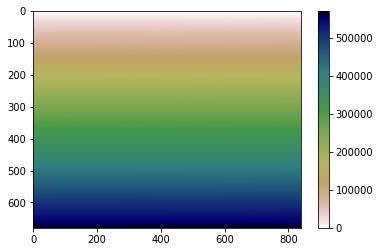

In [193]:
plt.imshow(rp, cmap="gist_earth_r");
plt.colorbar();

In [170]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array, dtype):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Float64
    outRaster = driver.Create(newRasterfn, cols, rows, 1, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array, dtype):
    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr, dtype) # convert array to raster


if __name__ == "__main__":
    rasterOrigin = (112.003,-43.9975)
    pixelWidth = 0.05
    pixelHeight = 0.05
    newRasterfn = 'new_test.tif'
    array = D8_flow_directions_national
    main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array, D8_flow_directions_national.dtype)